In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from catboost import Pool, CatBoostClassifier, cv

pd.options.display.max_columns
pd.set_option('display.max_columns', None)

# Data Prep

In [109]:
X_train = pd.read_csv('https://raw.githubusercontent.com/mkleinbort/Kaggle-COMPAS/main/train/X_train.csv', index_col='id')
y_train = pd.read_csv('https://raw.githubusercontent.com/mkleinbort/Kaggle-COMPAS/main/train/y_train.csv', squeeze=True)
X_test = pd.read_csv ('https://raw.githubusercontent.com/mkleinbort/Kaggle-COMPAS/main/test/X_test.csv')

In [110]:
df = X_train

df = df.drop(['v_screening_date'], axis=1) # duplicate of 'screening_date'
df = df.drop(['v_type_of_assessment'], axis=1) # duplicate of 'type_of_assessment'
df = df.drop(['type_of_assessment'], axis=1) # 0 variance

df['target'] = y_train.to_list() # set target row-wise (ignoring indices)

In [111]:
# Engineer a new targets 
df['target_int'] = df['target'].replace({'No-Recidivism': 0, 'Non-Violent': 1, 'Violent': 2}) # so we can do regression
df['target_bool'] = df['target'].replace({'No-Recidivism': 0, 'Non-Violent': 1, 'Violent': 1}) # 0 - no-rec, 1 - rec
target_cols = ['target', 'target_int', 'target_bool']

In [112]:
df.columns

Index(['name', 'first', 'last', 'sex', 'date_of_birth', 'age', 'age_group',
       'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out',
       'c_offense_date', 'c_arrest_date', 'c_charge_degree', 'c_charge_desc',
       'r_jail_in', 'r_jail_out', 'screening_date', 'in_custody',
       'out_custody', 'start', 'target', 'target_int', 'target_bool'],
      dtype='object')

In [113]:
# Engineer new date based features

"""
Custody: when someone is kept in prison until they go to court
Screening:  involves  using  a  brief  instrument  to  quickly  capture basic information 
    about a person’s risk to reoffend and is  used  to  determine  if  a  more  comprehensive  assessment
    is  warranted.  In  a  jail  setting,  everyone,  regardless  of  legal  status, should be screened 
    at booking.  Risk  screening  divides  the  jail  population  into  high-,  medium-,  and  low-risk 
    categories,  making  it  possible  to  direct  intervention  resources  first  to  the highest-risk individuals.



- c_arrest_date and c_offense_date are mutually exclusive and one of them is 99.8% likely to be filled
- c_arrest_date and c_are mutually exclusive
- start is number of days between c_jail_in and c_jail_out, maybe worth engineering total hours/minutes between
- screening_date is always filled
"""



days_cols = []

def days_between(d1, d2):
    try:
        try:
            d1 = datetime.strptime(d1, "%Y-%m-%d")
        except ValueError:
            d1 = datetime.strptime(d1, "%Y-%m-%d %H:%M:%S")
            
        try:
            d2 = datetime.strptime(d2, "%Y-%m-%d")
        except ValueError:
            d2 = datetime.strptime(d2, "%Y-%m-%d %H:%M:%S")
        return abs((d2 - d1).days)
    except TypeError as e:
        return None

# mutually exclusive and one of them is always filled
df['c_bad_date'] = df['c_arrest_date'].fillna(df['c_offense_date']).fillna(df['in_custody']).fillna(df['screening_date'])

# how many days in custody
df['custody_days'] = df.apply(lambda x: days_between(x.out_custody, x.in_custody), axis=1)

# how quickly after going into custody did the person get screened (might indicate something?)
df['in_custody_to_screening_days'] = df.apply(lambda x: days_between(x.in_custody, x.screening_date), axis=1)

# questionable col because it is age related... Also corr=1 with age
df['birth_to_bad_days'] = df.apply(lambda x: days_between(x.date_of_birth, x.c_bad_date), axis=1)

# How many days passed until recitivism occcured. Golden feature!
df['days_until_recitivism'] = df.apply(lambda x: days_between(x.c_jail_out, x.r_jail_in), axis=1)

date_cols = [ 
    'c_arrest_date', 
    'c_offense_date',
    'screening_date', 
    'in_custody', 
    'out_custody', 
    'date_of_birth',
    'c_jail_in',
    'c_jail_out',
    'r_jail_in',
    'r_jail_out',

    # engineered
    'c_bad_date'
]

duration_cols = [
    'days_b_screening_arrest',
    'custody_days',
    'in_custody_to_screening_days',
    'birth_to_bad_days',
    'days_until_recitivism',
]


In [114]:

df[['c_charge_desc', 'c_charge_degree']]

,c_charge_desc,c_charge_degree
id,,
2677,arrest case no charge,F
548,Grand Theft in the 3rd Degree,F
4483,Grand Theft in the 3rd Degree,F
9476,Felony Driving While Lic Suspd,F
199,arrest case no charge,F
...,...,...
7351,Grand Theft in the 3rd Degree,F
364,Grand Theft in the 3rd Degree,F
1054,arrest case no charge,F


In [115]:
# Has recidivism occured?
df['has_r_jail_in'] = df['r_jail_in'].notna()
df['has_r_jail_out'] = df['r_jail_out'].notna()

In [116]:
# fill missing values
df['c_charge_desc'] = df['c_charge_desc'].fillna('missing') 

df.head()

,name,first,last,sex,date_of_birth,age,age_group,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_offense_date,c_arrest_date,c_charge_degree,c_charge_desc,r_jail_in,r_jail_out,screening_date,in_custody,out_custody,start,target,target_int,target_bool,c_bad_date,custody_days,in_custody_to_screening_days,birth_to_bad_days,days_until_recitivism,has_r_jail_in,has_r_jail_out
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2677,nicholas staggewise,nicholas,staggewise,Male,1994-02-28,22,Less than 25,Caucasian,0,0,0,2,-1.0,2013-09-23 09:01:58,2013-09-27 03:54:42,NaN,2013-09-23,F,arrest case no charge,NaN,NaN,2013-09-24,2013-09-23,2013-09-27,3,No-Recidivism,0,0,2013-09-23,4.0,1.0,7147,NaN,False,False
548,newton smith,newton,smith,Male,1995-01-28,21,Less than 25,African-American,0,1,0,1,-1.0,2013-06-16 12:36:42,2013-06-16 07:01:42,2013-06-15,NaN,F,Grand Theft in the 3rd Degree,NaN,NaN,2013-06-17,2013-06-16,2013-06-16,0,Violent,2,1,2013-06-15,0.0,1.0,6713,NaN,False,False
4483,terrance irvin,terrance,irvin,Male,1984-04-10,32,25 - 45,African-American,0,0,0,6,-1.0,2013-10-11 05:38:14,2013-10-15 07:11:17,2013-10-11,NaN,F,Grand Theft in the 3rd Degree,2013-12-21,2014-02-21,2013-10-12,2013-10-11,2013-10-15,3,Non-Violent,1,1,2013-10-11,4.0,1.0,10776,66.0,True,True
9476,jaimie peterson,jaimie,peterson,Female,1986-01-02,30,25 - 45,African-American,0,0,0,3,-1.0,2014-01-11 06:56:43,2014-01-12 02:17:00,2014-01-11,NaN,F,Felony Driving While Lic Suspd,NaN,NaN,2014-01-12,2014-01-11,2014-01-12,0,No-Recidivism,0,0,2014-01-11,1.0,1.0,10236,NaN,False,False
199,ritesh sukhlall,ritesh,sukhlall,Male,1987-05-12,28,25 - 45,Caucasian,0,0,0,2,NaN,NaN,NaN,NaN,2013-03-21,F,arrest case no charge,NaN,NaN,2013-08-29,NaN,NaN,0,No-Recidivism,0,0,2013-03-21,NaN,NaN,9445,NaN,False,False


In [117]:
df['all_priors'] = df[[
    'juv_fel_count',
    'juv_misd_count', 
    'juv_other_count',
    'priors_count'
]].sum(axis=1)



In [118]:
cols = [
#     'name', useless
#     'first', useless
#     'last', useless
#     'sex', # 0 importance + potential bias
#     'date_of_birth', date
#     'age', # innapropriate bias
#     'age_group', # innapropriate bias
#     'race', # innapropriate bias
    # 'juv_fel_count', # form part of all priors
    # 'juv_misd_count', # form part of all priors
    # 'juv_other_count', # form part of all priors
    # 'priors_count', # form part of all priors
    'all_priors',
    'days_b_screening_arrest',
#     'c_jail_in', date
#     'c_jail_out',date
#     'c_offense_date', date
#     'c_arrest_date', date
#     'c_charge_degree',  # 0 importance
    'c_charge_desc',
#     'r_jail_in', date
#     'r_jail_out', date
#     'screening_date', date
#     'in_custody', date
#     'out_custody', date
    'start', 
#     'target', target
#     'target_int', target
#     'target_bool', target
#     'c_bad_date', date
    'custody_days',
    'in_custody_to_screening_days',
#     'birth_to_bad_days', # corr=1 with age
    'has_r_jail_in', 
#     'has_r_jail_out', # corr=1 with r_jail_in
    'days_until_recitivism', # golden feature!
]

cat_cols = [
#     'sex',  # innapropriate bias
#     'age_group', # innapropriate bias
#     'race', # innapropriate bias
#     'c_charge_degree', # 0 importance
    'c_charge_desc',
]

<AxesSubplot:>

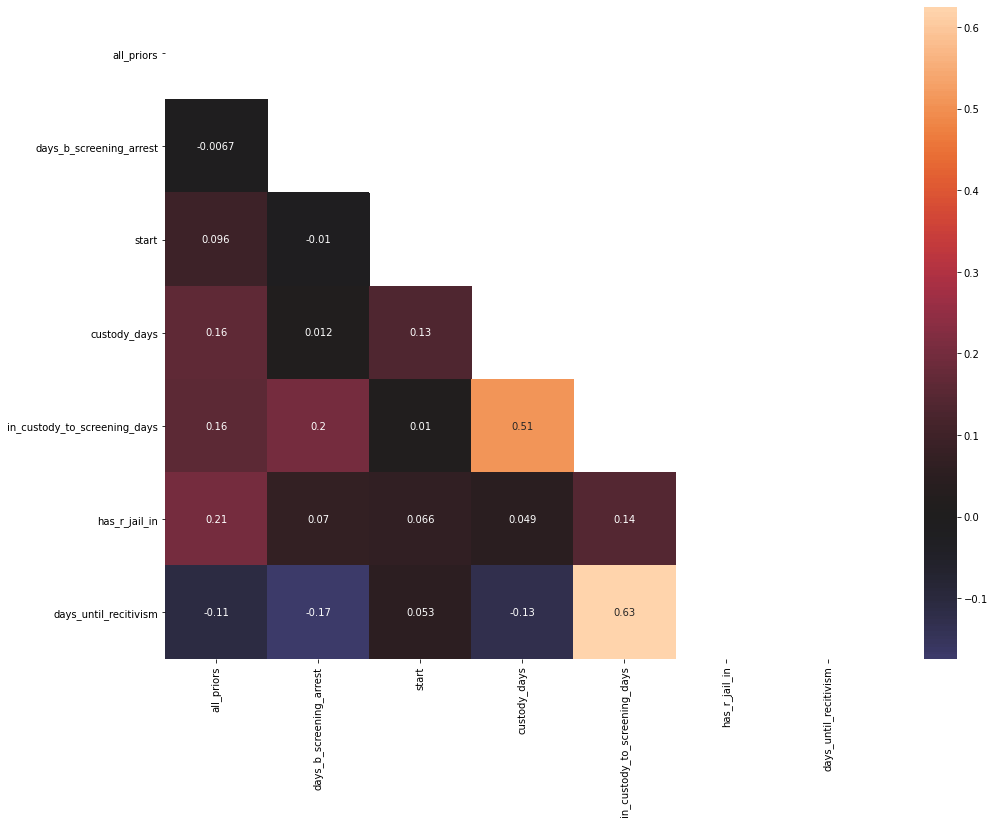

In [119]:
# Numeric correlations across numeric features
f, ax = plt.subplots(figsize=(16, 12))
corr = df[cols].corr()
mask = np.triu(corr)
sns.heatmap(corr.select_dtypes('number'), annot=True, center=0, mask=mask)

In [120]:
df[cols].head()

,all_priors,days_b_screening_arrest,c_charge_desc,start,custody_days,in_custody_to_screening_days,has_r_jail_in,days_until_recitivism
id,,,,,,,,
2677,2,-1.0,arrest case no charge,3,4.0,1.0,False,NaN
548,2,-1.0,Grand Theft in the 3rd Degree,0,0.0,1.0,False,NaN
4483,6,-1.0,Grand Theft in the 3rd Degree,3,4.0,1.0,True,66.0
9476,3,-1.0,Felony Driving While Lic Suspd,0,1.0,1.0,False,NaN
199,2,NaN,arrest case no charge,0,NaN,NaN,False,NaN


In [121]:
races = df.race.unique()
sexes = df.sex.unique()
age_groups = df.age_group.unique()

sexes

array(['Male', 'Female'], dtype=object)

# Cross Validation

In [122]:
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
import collections

kf = RepeatedStratifiedKFold(n_splits=6, n_repeats=10, random_state=42)

# X_train, X_test, y_train, y_test = train_test_split(df[cols], df['target'], test_size=0.2)

roc_aucs = []
roc_aucs_race = collections.defaultdict(list)
roc_aucs_age = collections.defaultdict(list)
roc_aucs_sex = collections.defaultdict(list)

feature_importances = []
for split_idx, (train, test) in enumerate(kf.split(df[cols], df['race'])): # Stratified on race
    train_df = df.iloc[train].reset_index(drop=True)
    eval_df = df.iloc[test].reset_index(drop=True)
    
    train_dataset = Pool(data=train_df[cols],
                         label=train_df.target,
                         cat_features=cat_cols)

    eval_dataset = Pool(data=eval_df[cols],
                        label=eval_df.target,
                        cat_features=cat_cols)
    
    y_eval = pd.get_dummies(eval_df.target).to_numpy()
    
    # Initialize CatBoostClassifier
    model = CatBoostClassifier(iterations=10,
                               learning_rate=1,
                               depth=2,
                               loss_function='MultiClass')
    # Fit model
    model.fit(train_dataset, verbose=False)
    # Get predicted classes
    preds_class = model.predict(eval_dataset)
    # Get predicted probabilities for each class
    preds_proba = model.predict_proba(eval_dataset)
    # Get predicted RawFormulaVal
    preds_raw = model.predict(eval_dataset, 
                              prediction_type='RawFormulaVal')
    
    
    roc_auc = roc_auc_score(y_eval, preds_proba, multi_class="ovo")
    roc_aucs.append(roc_auc)
    for race in races:
        eval_race_df = eval_df[eval_df['race'] == race]
        try:
            roc_aucs_race[race].append(roc_auc_score(y_eval[eval_race_df.index], preds_proba[eval_race_df.index], multi_class="ovo"))
        except Exception as e:
            pass
    
    for sex in sexes:
        eval_sex_df = eval_df[eval_df['sex'] == sex]
        try:
            roc_aucs_sex[sex].append(roc_auc_score(y_eval[eval_sex_df.index], preds_proba[eval_sex_df.index], multi_class="ovo"))
        except Exception as e:
            pass
        
    for age in age_groups:
        eval_age_df = eval_df[eval_df['age_group'] == age]
        try:
            roc_aucs_age[age].append(roc_auc_score(y_eval[eval_age_df.index], preds_proba[eval_age_df.index], multi_class="ovo"))
        except Exception as e:
            pass
        
    roc_aucs.append(roc_auc)
    feature_importances.append(model.get_feature_importance())
    # avg_precs.append(avg_prec)
    print(f'Split {split_idx+1}: ROC-AUC: {roc_auc*100:.2f}%')

Split 1: ROC-AUC: 85.12%
Split 2: ROC-AUC: 88.12%
Split 3: ROC-AUC: 87.30%
Split 4: ROC-AUC: 89.14%
Split 5: ROC-AUC: 88.22%
Split 6: ROC-AUC: 88.04%
Split 7: ROC-AUC: 87.65%
Split 8: ROC-AUC: 82.16%
Split 9: ROC-AUC: 86.31%
Split 10: ROC-AUC: 88.69%
Split 11: ROC-AUC: 92.47%
Split 12: ROC-AUC: 87.18%
Split 13: ROC-AUC: 89.63%
Split 14: ROC-AUC: 90.34%
Split 15: ROC-AUC: 88.91%
Split 16: ROC-AUC: 91.36%
Split 17: ROC-AUC: 86.73%
Split 18: ROC-AUC: 83.74%
Split 19: ROC-AUC: 84.54%
Split 20: ROC-AUC: 89.21%
Split 21: ROC-AUC: 88.98%
Split 22: ROC-AUC: 88.10%
Split 23: ROC-AUC: 86.48%
Split 24: ROC-AUC: 87.72%
Split 25: ROC-AUC: 90.36%
Split 26: ROC-AUC: 87.95%
Split 27: ROC-AUC: 87.67%
Split 28: ROC-AUC: 89.76%
Split 29: ROC-AUC: 87.51%
Split 30: ROC-AUC: 87.00%
Split 31: ROC-AUC: 91.31%
Split 32: ROC-AUC: 88.81%
Split 33: ROC-AUC: 87.64%
Split 34: ROC-AUC: 86.84%
Split 35: ROC-AUC: 87.21%
Split 36: ROC-AUC: 86.48%
Split 37: ROC-AUC: 90.41%
Split 38: ROC-AUC: 88.87%
Split 39: ROC-AUC: 85

In [123]:
# Evaluation
print(f'ROC-AUC {np.mean(roc_aucs)*100:.2f}%')

# Calculate ROC-AUC mean per subset
mean_roc_aucs_race = dict()
mean_roc_aucs_sex = dict()
mean_roc_aucs_age = dict()

for race, aucs in roc_aucs_race.items():
    mean_roc_aucs_race[race] = np.mean(aucs)
for sex, aucs in roc_aucs_sex.items():
    mean_roc_aucs_sex[sex] = np.mean(aucs)
for age, aucs in roc_aucs_age.items():
    mean_roc_aucs_age[age] = np.mean(aucs)

# Calculate ROC-AUC standard deviation per subset
race_std = np.std([x for x in mean_roc_aucs_race.values() if np.isfinite(x)])
sex_std = np.std([x for x in mean_roc_aucs_sex.values() if np.isfinite(x)])
age_std = np.std([x for x in mean_roc_aucs_age.values() if np.isfinite(x)])

# Calculate fairness per subset
race_fairness = 1 - np.sqrt(race_std)
sex_fairness = 1 - np.sqrt(sex_std)
age_fairness = 1 - np.sqrt(age_std)

print(f'Race fairness: {race_fairness*100:.2f}%')
print(f'Sex fairness: {sex_fairness*100:.2f}%')
print(f'Age fairness: {age_fairness*100:.2f}%')

ROC-AUC 87.94%
Race fairness: 81.33%
Sex fairness: 90.83%
Age fairness: 84.46%


/mnt/c/Users/emmar/Documents/Projects/Caggle/compas-comp/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/c/Users/emmar/Documents/Projects/Caggle/compas-comp/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<AxesSubplot:ylabel='race'>

<AxesSubplot:ylabel='sex'>

<AxesSubplot:ylabel='age'>

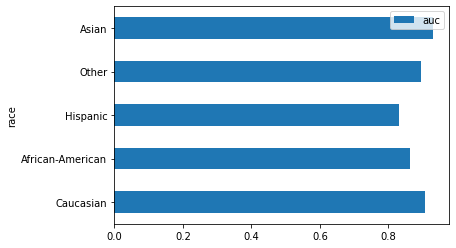

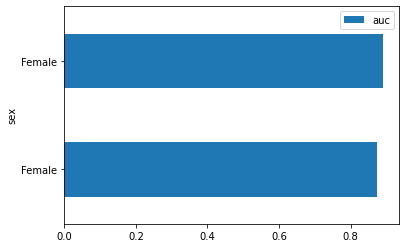

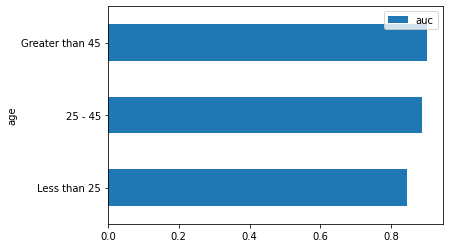

In [124]:
race_auc_df = pd.DataFrame({'race': races, 'auc': [mean_roc_aucs_race[race] for race in races]})
sex_auc_df = pd.DataFrame({'sex': sex, 'auc': [mean_roc_aucs_sex[sex] for sex in sexes]})
age_auc_df = pd.DataFrame({'age': age_groups, 'auc': [mean_roc_aucs_age[age] for age in age_groups]})
                     
display(race_auc_df[race_auc_df['auc'].notna()].plot.barh(x='race'))
display(sex_auc_df[sex_auc_df['auc'].notna()].plot.barh(x='sex'))
display(age_auc_df[age_auc_df['auc'].notna()].plot.barh(x='age'))

,feature,importance,std,min,max
6,has_r_jail_in,70.026436,4.490840,62.443409,81.089040
0,all_priors,12.470023,2.686492,7.731393,17.411496
7,days_until_recitivism,11.044547,3.178067,6.015560,19.307500
4,custody_days,2.332201,1.593088,0.000000,7.247136
5,in_custody_to_screening_days,2.098587,1.177790,0.000000,5.776840
1,days_b_screening_arrest,0.980088,0.683103,0.021721,3.462458
3,start,0.876738,1.205568,0.000000,5.600908
2,c_charge_desc,0.171380,0.416650,0.000000,1.616525


<AxesSubplot:ylabel='feature'>

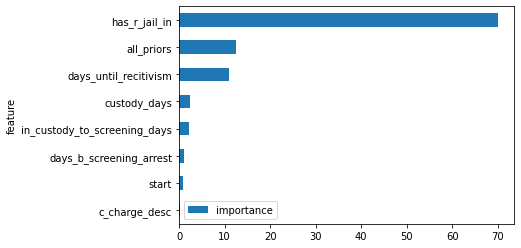

In [125]:
# Feature importances
fi_df = pd.DataFrame({'feature': cols})
fi_df['importance'] = np.mean(feature_importances, axis=0)
fi_df['std'] = np.std(feature_importances, axis=0)
fi_df['min'] = np.min(feature_importances, axis=0)
fi_df['max'] = np.max(feature_importances, axis=0)
fi_df = fi_df.sort_values('importance', ascending=False)
display(fi_df)
display(fi_df[['feature', 'importance']].sort_values('importance', ascending=True).plot.barh(x='feature'))

## Try TF

In [126]:

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
import collections
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# kf = RepeatedStratifiedKFold(n_splits=6, n_repeats=10, random_state=42)

# feature_importances = []
# for split_idx, (train, test) in enumerate(kf.split(df[cols], df['race'])): # Stratified on race
#     train_df = df.iloc[train].reset_index(drop=True)
#     test_df = df.iloc[test].reset_index(drop=True)
feature_cols = cols.append("target_bool")

train, test = train_test_split(df[cols], test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

2428 train examples
607 validation examples
759 test examples


In [127]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target_bool')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [128]:
batch_size = 5 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [129]:
train_ds

<BatchDataset shapes: ({all_priors: (None,), days_b_screening_arrest: (None,), c_charge_desc: (None,), start: (None,), custody_days: (None,), in_custody_to_screening_days: (None,), has_r_jail_in: (None,), days_until_recitivism: (None,)}, (None,)), types: ({all_priors: tf.int64, days_b_screening_arrest: tf.float64, c_charge_desc: tf.string, start: tf.int64, custody_days: tf.float64, in_custody_to_screening_days: tf.float64, has_r_jail_in: tf.bool, days_until_recitivism: tf.float64}, tf.int64)>